In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
path = "/mnt/b405f74a-72c4-4e5a-8bd4-d763618331be/flower_data/train"

size = (225, 225)

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



flowerData = torchvision.datasets.ImageFolder(path, transform=transform)




In [3]:
dataLoader = torch.utils.data.DataLoader(flowerData,
                                          batch_size=20,
                                          shuffle=True,
                                          num_workers=0)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

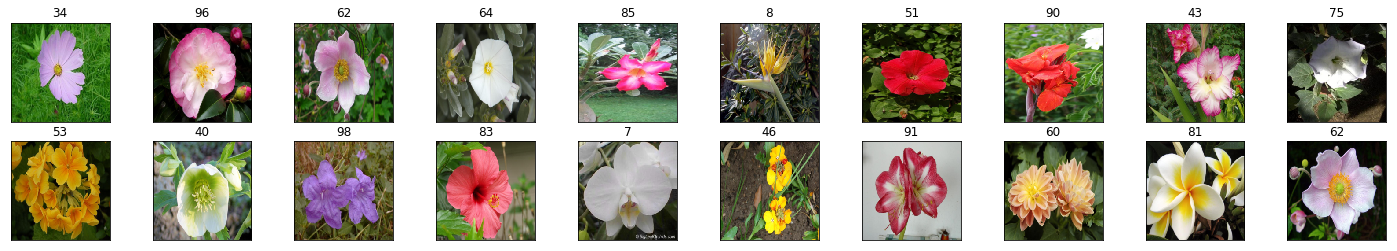

In [6]:
# obtain one batch of training images
dataiter = iter(dataLoader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(flowerData.classes[labels[idx]])